In [2]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [5]:
# # Where to store / read your cached activities
DATA_PATH = r"C:\Users\RuiCoelho\Desktop\Rui Coelho\Me\Strava_Analysis\data\strava_activities.parquet"

In [6]:
def load_activities_from_parquet(path: str) -> pd.DataFrame:
    """
    Load previously saved activities from Parquet.
    """
    if not os.path.exists(path):
        raise FileNotFoundError(
            f"{path} not found. Run the extraction mode first to create it."
        )
    df = pd.read_parquet(path)
    print(f"Loaded {len(df)} activities from {path}")
    return df

def prepare_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean and enrich the DataFrame with useful derived columns:
    - date / year / month / week / weekday
    - distance_km
    - moving_hours
    """
    df = df.copy()

    # Ensure datetime
    df["start_date_local"] = pd.to_datetime(df["start_date_local"], errors="coerce")

    # Basic date parts
    df["date"] = df["start_date_local"].dt.date
    df["year"] = df["start_date_local"].dt.year
    df["month"] = df["start_date_local"].dt.month
    df["week"] = df["start_date_local"].dt.isocalendar().week.astype("Int64")
    df["weekday"] = df["start_date_local"].dt.weekday  # Monday=0, Sunday=6

    # Distance: Strava distance is in meters
    if "distance" in df.columns:
        df["distance_km"] = df["distance"].fillna(0) / 1000.0
    else:
        df["distance_km"] = 0.0

    # Moving time: Strava moving_time is in seconds
    if "moving_time" in df.columns:
        df["moving_hours"] = df["moving_time"].fillna(0) / 3600.0
    else:
        df["moving_hours"] = 0.0

    # Ensure sport_type exists (older activities might only have 'type')
    if "sport_type" not in df.columns:
        df["sport_type"] = df.get("type", "Unknown")
    else:
        df["sport_type"] = df["sport_type"].fillna(df.get("type", "Unknown"))

    return df


df = load_activities_from_parquet(DATA_PATH)
df = prepare_dataframe(df)

Loaded 2046 activities from C:\Users\RuiCoelho\Desktop\Rui Coelho\Me\Strava_Analysis\data\strava_activities.parquet


In [12]:
def get_year_overview(df: pd.DataFrame, year: int) -> dict:
    """
    Compute year-level overview:
    - total km
    - total hours
    - number of activities
    - totals by sport_type (km, hours, count)
    Returns a dictionary with summary and per-sport-type DataFrames.
    """
    year_df = df[df["year"] == year].copy()

    if year_df.empty:
        print(f"No activities found for year {year}.")
        return {
            "year": year,
            "summary": None,
            "by_sport": None,
            "by_month": None,
        }

    total_km = year_df["distance_km"].sum()
    total_hours = year_df["moving_hours"].sum()
    n_activities = len(year_df)

    print(f"Overview for {year}:")
    print(f"  Total activities: {n_activities}")
    print(f"  Total distance:   {total_km:.1f} km")
    print(f"  Total moving:     {total_hours:.1f} hours")

    # Totals by sport_type
    by_sport = (
        year_df.groupby("sport_type")
        .agg(
            total_km=("distance_km", "sum"),
            total_hours=("moving_hours", "sum"),
            n_activities=("id", "count") if "id" in year_df.columns else ("distance_km", "count"),
        )
        .sort_values("total_km", ascending=False)
    )

    print("\nDistance and time by sport_type:")
    print(by_sport)

    # Monthly totals (all sports)
    by_month = (
        year_df.groupby("month")
        .agg(
            total_km=("distance_km", "sum"),
            total_hours=("moving_hours", "sum"),
            n_activities=("distance_km", "count"),
        )
        .sort_index()
    )

    return {
        "year": year,
        "summary": {
            "total_km": total_km,
            "total_hours": total_hours,
            "n_activities": n_activities,
        },
        "by_sport": by_sport,
        "by_month": by_month,
    }


def plot_year_overview_sport_type(df: pd.DataFrame, year: int) -> None:
    """
    Bar chart of total km per sport_type for the specified year.
    """
    overview = get_year_overview(df, year)
    by_sport = overview["by_sport"]

    if by_sport is None or by_sport.empty:
        return

    plt.figure(figsize=(10, 5))
    plt.bar(by_sport.index, by_sport["total_km"])
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Distance (km)")
    plt.title(f"Total Distance per Sport Type - {year}")
    plt.tight_layout()
    plt.show()


def plot_year_monthly_distance(df: pd.DataFrame, year: int) -> None:
    """
    Bar chart of total km per month for the specified year.
    """
    overview = get_year_overview(df, year)
    by_month = overview["by_month"]

    if by_month is None or by_month.empty:
        return

    plt.figure(figsize=(10, 5))
    plt.bar(by_month.index.astype(str), by_month["total_km"])
    plt.xlabel("Month")
    plt.ylabel("Distance (km)")
    plt.title(f"Total Distance per Month - {year}")
    plt.tight_layout()
    plt.show()


def get_year_summary(df: pd.DataFrame, year: int) -> pd.Series:
    """
    Return a simple summary Series for a given year.
    """
    year_df = df[df["year"] == year]

    if year_df.empty:
        return pd.Series(
            {
                "year": year,
                "total_km": 0.0,
                "total_hours": 0.0,
                "n_activities": 0,
                "n_active_days": 0,
            }
        )

    summary = pd.Series(
        {
            "year": year,
            "total_km": year_df["distance_km"].sum(),
            "total_hours": year_df["moving_hours"].sum(),
            "n_activities": len(year_df),
            "n_active_days": year_df["date"].nunique(),
        }
    )
    return summary


def compare_two_years(df: pd.DataFrame, year_a: int, year_b: int) -> pd.DataFrame:
    """
    Compare basic stats between two years (e.g. 2024 vs 2025).
    Returns a 2-row DataFrame.
    """
    s_a = get_year_summary(df, year_a)
    s_b = get_year_summary(df, year_b)

    comp_df = pd.DataFrame([s_a, s_b]).set_index("year")
    print("\nComparison:")
    print(comp_df)
    diff = comp_df.diff().iloc[-1]  # year_b - year_a
    print(f"\nDifferences (year {year_b} - year {year_a}):")
    print(diff)

    return comp_df


def plot_compare_two_years_distance(df: pd.DataFrame, year_a: int, year_b: int) -> None:
    """
    Bar chart comparing total distance and hours between two years.
    """
    comp_df = compare_two_years(df, year_a, year_b)

    if comp_df["total_km"].sum() == 0 and comp_df["total_hours"].sum() == 0:
        return

    years = comp_df.index.astype(int)

    # Distance comparison
    plt.figure(figsize=(8, 4))
    plt.bar(years.astype(str), comp_df["total_km"])
    plt.ylabel("Distance (km)")
    plt.title(f"Total Distance Comparison: {year_a} vs {year_b}")
    plt.tight_layout()
    plt.show()

    # Hours comparison
    plt.figure(figsize=(8, 4))
    plt.bar(years.astype(str), comp_df["total_hours"])
    plt.ylabel("Moving Time (hours)")
    plt.title(f"Total Moving Time Comparison: {year_a} vs {year_b}")
    plt.tight_layout()
    plt.show()


def plot_weekly_distance(df: pd.DataFrame, year: int) -> None:
    """
    Extra: Weekly total distance trend for a given year.
    Good to see consistency over time.
    """
    year_df = df[df["year"] == year].copy()
    if year_df.empty:
        print(f"No activities for year {year}")
        return

    # Use the datetime index for resampling
    tmp = year_df.set_index("start_date_local")

    weekly = tmp["distance_km"].resample("W").sum()

    plt.figure(figsize=(12, 4))
    plt.plot(weekly.index, weekly.values)
    plt.ylabel("Distance (km)")
    plt.title(f"Weekly Distance Trend - {year}")
    plt.tight_layout()
    plt.show()

Overview for 2025:
  Total activities: 243
  Total distance:   5016.4 km
  Total moving:     329.3 hours

Distance and time by sport_type:
                 total_km  total_hours  n_activities
sport_type                                          
Ride            4288.6986   156.529167            80
VirtualRide      504.9726    15.879722            21
Canoeing          79.3604     8.166389            11
Hike              69.5287    18.076944             9
Run               66.0107     5.371667             7
VirtualRun         4.5000     0.366667             2
Tennis             2.0000     1.000000             1
Golf               1.0000     2.000000             1
Swim               0.2880     0.094167             1
WeightTraining     0.0000   121.862500           110
Overview for 2025:
  Total activities: 243
  Total distance:   5016.4 km
  Total moving:     329.3 hours

Distance and time by sport_type:
                 total_km  total_hours  n_activities
sport_type                       

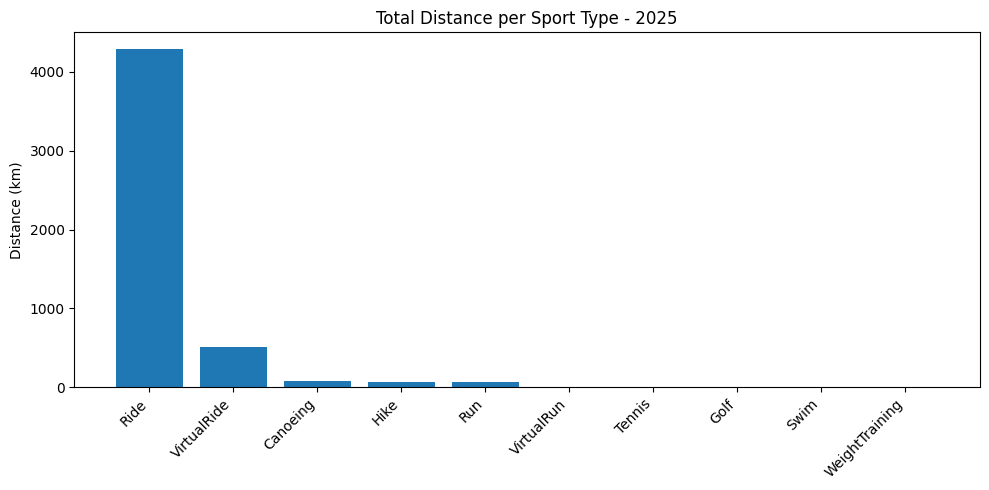

Overview for 2025:
  Total activities: 243
  Total distance:   5016.4 km
  Total moving:     329.3 hours

Distance and time by sport_type:
                 total_km  total_hours  n_activities
sport_type                                          
Ride            4288.6986   156.529167            80
VirtualRide      504.9726    15.879722            21
Canoeing          79.3604     8.166389            11
Hike              69.5287    18.076944             9
Run               66.0107     5.371667             7
VirtualRun         4.5000     0.366667             2
Tennis             2.0000     1.000000             1
Golf               1.0000     2.000000             1
Swim               0.2880     0.094167             1
WeightTraining     0.0000   121.862500           110


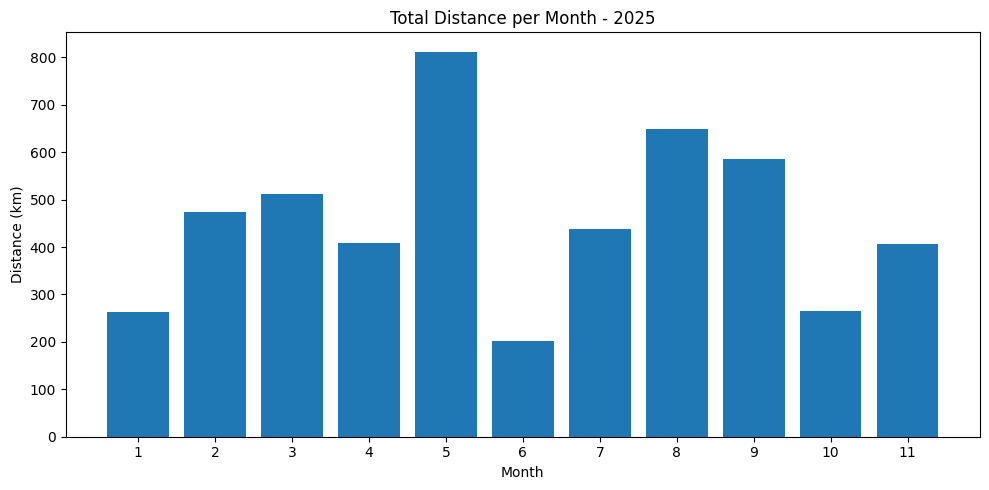

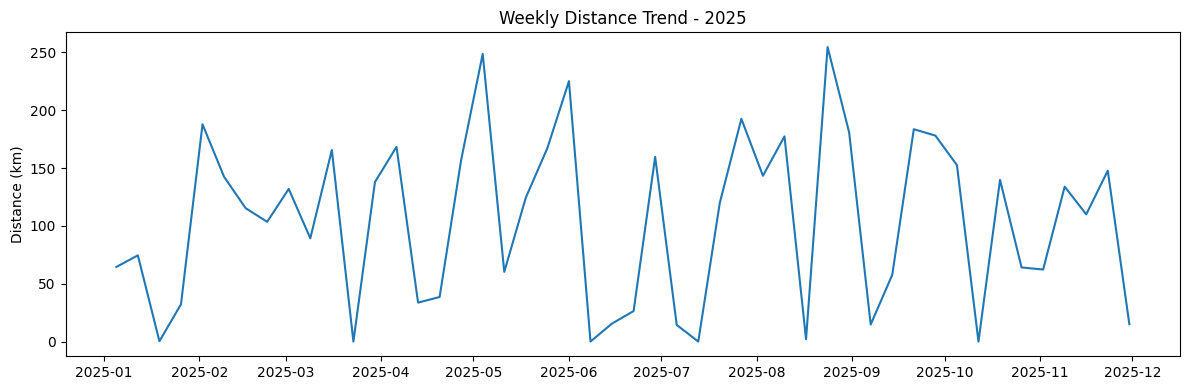


Comparison:
         total_km  total_hours  n_activities  n_active_days
year                                                       
2024.0  2931.0356   258.651667         198.0          183.0
2025.0  5016.3590   329.347222         243.0          218.0

Differences (year 2025 - year 2024):
total_km         2085.323400
total_hours        70.695556
n_activities       45.000000
n_active_days      35.000000
Name: 2025.0, dtype: float64

Comparison:
         total_km  total_hours  n_activities  n_active_days
year                                                       
2024.0  2931.0356   258.651667         198.0          183.0
2025.0  5016.3590   329.347222         243.0          218.0

Differences (year 2025 - year 2024):
total_km         2085.323400
total_hours        70.695556
n_activities       45.000000
n_active_days      35.000000
Name: 2025.0, dtype: float64


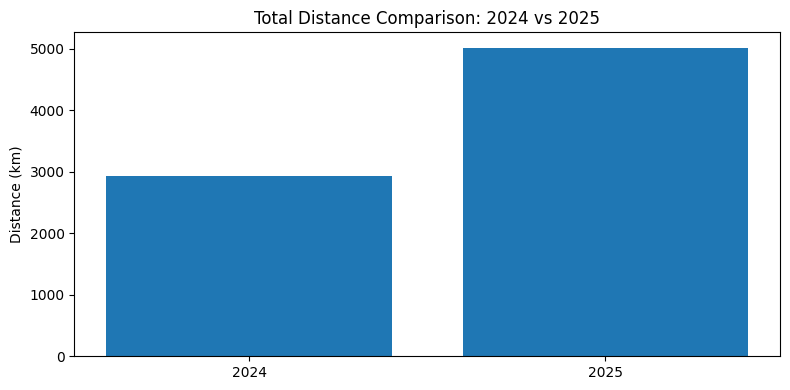

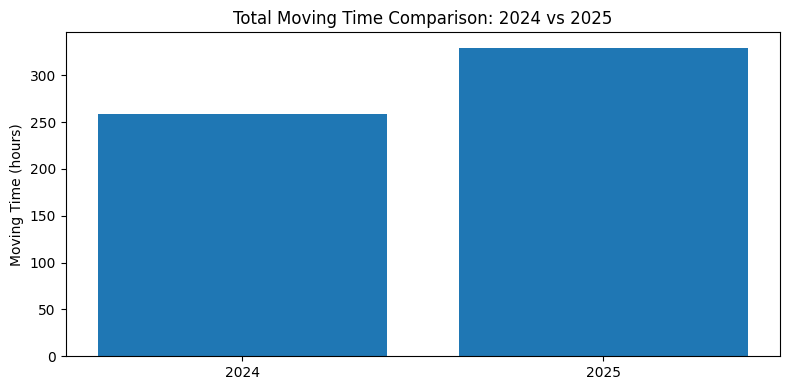

In [14]:
# ---- Year overview ----
year = 2025
_ = get_year_overview(df, year)
plot_year_overview_sport_type(df, year)
plot_year_monthly_distance(df, year)
plot_weekly_distance(df, year)

# ---- Compare years ----
compare_two_years(df, 2024, 2025)
plot_compare_two_years_distance(df, 2024, 2025)

In [15]:
# 1️⃣ Consistency & Habit Tracking
# 1.1 Training streaks (all-time or per year)

from datetime import date

def compute_training_streaks(df: pd.DataFrame, year: int | None = None) -> dict:
    """
    Compute longest and current training streak (consecutive active days).
    If year is given, restrict to that year; otherwise uses all data.
    Returns dict with:
        - longest_streak
        - longest_streak_start
        - longest_streak_end
        - current_streak
    """
    tmp = df.copy()
    if year is not None:
        tmp = tmp[tmp["year"] == year]

    if tmp.empty:
        print("No activities in selected period.")
        return {
            "longest_streak": 0,
            "longest_streak_start": None,
            "longest_streak_end": None,
            "current_streak": 0,
        }

    days = sorted(tmp["date"].dropna().unique())
    if not days:
        return {
            "longest_streak": 0,
            "longest_streak_start": None,
            "longest_streak_end": None,
            "current_streak": 0,
        }

    longest = 1
    longest_start = days[0]
    longest_end = days[0]
    current = 1
    current_start = days[0]

    for i in range(1, len(days)):
        if (days[i] - days[i - 1]).days == 1:
            current += 1
        else:
            if current > longest:
                longest = current
                longest_start = current_start
                longest_end = days[i - 1]
            current = 1
            current_start = days[i]

    # Check last streak
    if current > longest:
        longest = current
        longest_start = current_start
        longest_end = days[-1]

    # Current streak = consecutive days until last activity date
    today = date.today()
    if (today - days[-1]).days == 0:
        current_streak = current
    else:
        current_streak = 0

    res = {
        "longest_streak": int(longest),
        "longest_streak_start": longest_start,
        "longest_streak_end": longest_end,
        "current_streak": int(current_streak),
    }

    print("Training streaks" + (f" ({year})" if year else "") + ":")
    print(f"  Longest streak: {longest} days ({longest_start} → {longest_end})")
    print(f"  Current streak: {current_streak} days")
    return res


# 1.2 Weekly load stability + risk flags

def weekly_load_with_rolling(df: pd.DataFrame, year: int, window: int = 4) -> pd.DataFrame:
    """
    Weekly distance for a given year + rolling mean/std + % change.
    Also prints weeks with sharp increases (>30% by default).
    """
    year_df = df[df["year"] == year].copy()
    if year_df.empty:
        print(f"No activities for {year}")
        return pd.DataFrame()

    tmp = year_df.set_index("start_date_local")
    weekly = tmp["distance_km"].resample("W-MON").sum()  # weeks ending Monday

    weekly_df = pd.DataFrame({"total_km": weekly})
    weekly_df["rolling_mean_km"] = weekly_df["total_km"].rolling(window).mean()
    weekly_df["rolling_std_km"] = weekly_df["total_km"].rolling(window).std()
    weekly_df["pct_change_vs_prev"] = weekly_df["total_km"].pct_change()

    # Simple risk flag: > 30% increase vs previous week
    risk_weeks = weekly_df[weekly_df["pct_change_vs_prev"] > 0.3]
    if not risk_weeks.empty:
        print(f"⚠️ Weeks with >30% load increase in {year}:")
        for idx, row in risk_weeks.iterrows():
            print(f"  Week starting {idx.date()}: {row['total_km']:.1f} km "
                  f"({row['pct_change_vs_prev']*100:.0f}% vs prev)")

    # Plot
    plt.figure(figsize=(12, 4))
    plt.plot(weekly_df.index, weekly_df["total_km"], label="Weekly km")
    plt.plot(weekly_df.index, weekly_df["rolling_mean_km"], label=f"{window}-week rolling avg")
    plt.ylabel("Distance (km)")
    plt.title(f"Weekly Load & Rolling Average - {year}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return weekly_df

    # 1.3 Active vs rest days

def active_vs_rest_days(df: pd.DataFrame, year: int) -> dict:
    year_df = df[df["year"] == year].copy()
    if year_df.empty:
        print(f"No activities for {year}")
        return {}

    active_days = year_df["date"].nunique()
    total_days = 366 if pd.Timestamp(year=year, month=12, day=31).is_leap_year else 365
    rest_days = total_days - active_days
    sessions = len(year_df)

    stats = {
        "year": year,
        "active_days": int(active_days),
        "rest_days": int(rest_days),
        "sessions": int(sessions),
        "avg_sessions_per_active_day": sessions / active_days,
    }

    print(f"Active vs rest days - {year}:")
    for k, v in stats.items():
        print(f"  {k}: {v}")
    return stats



In [16]:
# 2️⃣ Cycling Performance & Indoor vs Outdoor
# 2.1 Speed metrics & trend

def add_speed_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds average_speed_kmh if Strava 'average_speed' (m/s) exists.
    """
    df = df.copy()
    if "average_speed" in df.columns:
        df["average_speed_kmh"] = df["average_speed"] * 3.6
    else:
        df["average_speed_kmh"] = pd.NA
    return df


def speed_trend_by_year(df: pd.DataFrame, sport_type: str = "Ride") -> pd.DataFrame:
    """
    Average speed per year for a given sport (default: Ride).
    """
    tmp = df[df["sport_type"] == sport_type].copy()
    if tmp.empty or "average_speed_kmh" not in tmp.columns:
        print(f"No speed data for sport_type={sport_type}")
        return pd.DataFrame()

    agg = (
        tmp.groupby("year")
        .agg(
            avg_speed_kmh=("average_speed_kmh", "mean"),
            median_speed_kmh=("average_speed_kmh", "median"),
            total_km=("distance_km", "sum"),
            n_activities=("distance_km", "count"),
        )
    )

    plt.figure(figsize=(8, 4))
    plt.plot(agg.index.astype(int), agg["avg_speed_kmh"], marker="o")
    plt.xlabel("Year")
    plt.ylabel("Avg speed (km/h)")
    plt.title(f"Average {sport_type} Speed by Year")
    plt.tight_layout()
    plt.show()

    print(agg)
    return agg
df = add_speed_columns(df)

# 2.2 Indoor vs outdoor efficiency
def indoor_vs_outdoor_stats(df: pd.DataFrame, year: int) -> pd.DataFrame:
    """
    Compare Ride vs VirtualRide for a given year.
    Returns a small summary DataFrame.
    """
    sub = df[(df["year"] == year) & (df["sport_type"].isin(["Ride", "VirtualRide"]))].copy()
    if sub.empty:
        print(f"No Ride/VirtualRide data for {year}")
        return pd.DataFrame()

    agg = (
        sub.groupby("sport_type")
        .agg(
            total_km=("distance_km", "sum"),
            total_hours=("moving_hours", "sum"),
            n_activities=("distance_km", "count"),
        )
    )
    agg["km_per_hour"] = agg["total_km"] / agg["total_hours"]

    print(f"Indoor vs outdoor - {year}:")
    print(agg)

    # Plot km & efficiency
    plt.figure(figsize=(8, 4))
    plt.bar(agg.index, agg["total_km"])
    plt.title(f"Total Distance - Indoor vs Outdoor ({year})")
    plt.ylabel("Distance (km)")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.bar(agg.index, agg["km_per_hour"])
    plt.title(f"Efficiency (km/h) - Indoor vs Outdoor ({year})")
    plt.ylabel("km/h")
    plt.tight_layout()
    plt.show()

    return agg


# 2.3 Climbing analysis

def climbing_analysis(df: pd.DataFrame, year: int) -> pd.DataFrame:
    """
    Uses total_elevation_gain (m) if available.
    Gives climbing per year, per sport, and per 100km.
    """
    if "total_elevation_gain" not in df.columns:
        print("No total_elevation_gain column in data.")
        return pd.DataFrame()

    year_df = df[df["year"] == year].copy()
    if year_df.empty:
        print(f"No activities for {year}")
        return pd.DataFrame()

    year_df["elev_gain_m"] = year_df["total_elevation_gain"].fillna(0)

    agg = (
        year_df.groupby("sport_type")
        .agg(
            total_km=("distance_km", "sum"),
            total_elev_m=("elev_gain_m", "sum"),
            n_activities=("distance_km", "count"),
        )
    )
    agg["m_per_km"] = agg["total_elev_m"] / agg["total_km"].replace(0, pd.NA)
    agg["m_per_100km"] = agg["m_per_km"] * 100

    print(f"Climbing stats - {year}:")
    print(agg.sort_values("total_elev_m", ascending=False))

    # Plot climbing per 100km for main endurance sports
    endurance = agg[agg["total_km"] > 0].sort_values("m_per_100km", ascending=False)
    if not endurance.empty:
        plt.figure(figsize=(10, 4))
        plt.bar(endurance.index, endurance["m_per_100km"])
        plt.ylabel("Elevation gain per 100 km (m)")
        plt.title(f"Climbing Density by Sport - {year}")
        plt.tight_layout()
        plt.show()

    return agg


In [17]:
# 3️⃣ Intensity Distribution & Training Load
# 3.1 Simple HR zones (if heart rate data exists)

def heart_rate_zone_distribution(
    df: pd.DataFrame,
    year: int,
    hr_max: int,
    sport_filter: str | None = "Ride",
) -> pd.DataFrame:
    """
    Very simple HR zoning:
    Z1: <60%, Z2: 60–70%, Z3: 70–80%, Z4: 80–90%, Z5: >90% of HRmax
    Uses average_heartrate if available.
    """
    if "average_heartrate" not in df.columns:
        print("No heart rate data available.")
        return pd.DataFrame()

    year_df = df[df["year"] == year].copy()
    if sport_filter:
        year_df = year_df[year_df["sport_type"] == sport_filter]

    year_df = year_df.dropna(subset=["average_heartrate"])
    if year_df.empty:
        print("No HR data for selection.")
        return pd.DataFrame()

    pct = year_df["average_heartrate"] / hr_max

    bins = [0, 0.6, 0.7, 0.8, 0.9, 10]
    labels = ["Z1", "Z2", "Z3", "Z4", "Z5"]
    year_df["hr_zone"] = pd.cut(pct, bins=bins, labels=labels, right=False)

    agg = (
        year_df.groupby("hr_zone")
        .agg(
            n_sessions=("id", "count") if "id" in year_df.columns else ("date", "count"),
            total_hours=("moving_hours", "sum"),
        )
        .reindex(labels)
        .fillna(0)
    )

    agg["hours_pct"] = agg["total_hours"] / agg["total_hours"].sum() * 100

    print(f"Heart rate zone distribution - {year} ({sport_filter})")
    print(agg)

    plt.figure(figsize=(6, 4))
    plt.bar(agg.index, agg["hours_pct"])
    plt.ylabel("Time in zone (%)")
    plt.title(f"HR Zone Distribution - {year} ({sport_filter})")
    plt.tight_layout()
    plt.show()

    return agg

# 3.2 Multi-sport training load score

def compute_training_load(
    df: pd.DataFrame,
    factors: dict | None = None,
) -> pd.DataFrame:
    """
    Create a simple training load score based on moving_hours and sport factors.
    factors: dict of sport_type -> multiplier (default values below).
    """
    if factors is None:
        factors = {
            "Ride": 1.0,
            "VirtualRide": 0.9,
            "Run": 1.3,
            "VirtualRun": 1.2,
            "Hike": 0.8,
            "Canoeing": 1.1,
            "Swim": 1.4,
            "WeightTraining": 0.9,
            # others default to 1.0
        }

    df = df.copy()
    df["sport_factor"] = df["sport_type"].map(factors).fillna(1.0)
    df["load_score"] = df["moving_hours"] * df["sport_factor"]

    return df


def plot_weekly_training_load(df_with_load: pd.DataFrame, year: int) -> pd.DataFrame:
    """
    Weekly sum of training load score for a given year, plus rolling average.
    """
    year_df = df_with_load[df_with_load["year"] == year].copy()
    if year_df.empty:
        print(f"No activities for {year}")
        return pd.DataFrame()

    tmp = year_df.set_index("start_date_local")
    weekly = tmp["load_score"].resample("W-MON").sum()
    weekly_df = pd.DataFrame({"load_score": weekly})
    weekly_df["rolling_4w"] = weekly_df["load_score"].rolling(4).mean()

    plt.figure(figsize=(12, 4))
    plt.plot(weekly_df.index, weekly_df["load_score"], label="Weekly load")
    plt.plot(weekly_df.index, weekly_df["rolling_4w"], label="4-week rolling avg")
    plt.ylabel("Load score (arbitrary units)")
    plt.title(f"Weekly Training Load - {year}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return weekly_df


In [18]:
# 4️⃣ Forecast & Goals
# 4.1 End-of-year distance forecast

def forecast_year_distance(df: pd.DataFrame, year: int) -> dict:
    """
    Simple forecast based on year-to-date daily average distance.
    """
    today = date.today()
    year_df = df[df["year"] == year].copy()
    if year_df.empty:
        print(f"No activities for {year}")
        return {}

    start = date(year, 1, 1)
    end = min(today, date(year, 12, 31))
    days_passed = (end - start).days + 1
    total_days = 366 if pd.Timestamp(year=year, month=12, day=31).is_leap_year else 365

    total_km = year_df["distance_km"].sum()
    daily_avg = total_km / days_passed
    forecast_total = daily_avg * total_days

    res = {
        "year": year,
        "current_total_km": total_km,
        "daily_avg_km": daily_avg,
        "forecast_total_km": forecast_total,
    }

    print(f"Forecast for {year}:")
    print(f"  Current km: {total_km:.1f}")
    print(f"  Daily avg (YTD): {daily_avg:.2f} km/day")
    print(f"  Forecast total: {forecast_total:.1f} km")

    return res

# 4.2 Goal tracking engine

def training_goals_progress(
    df: pd.DataFrame,
    year: int,
    goals: dict,
) -> dict:
    """
    goals example:
    {
        "total_km": 6000,
        "total_hours": 350,
        "n_active_days": 220,
        "n_activities": 250,
        "Ride.total_km": 5500,
    }
    """
    year_df = df[df["year"] == year].copy()
    if year_df.empty:
        print(f"No activities for {year}")
        return {}

    summary = get_year_summary(df, year)
    by_sport = (
        year_df.groupby("sport_type")
        .agg(total_km=("distance_km", "sum"), total_hours=("moving_hours", "sum"))
    )

    progress = {}
    for key, target in goals.items():
        if "." in key:
            sport, metric = key.split(".", 1)
            if sport in by_sport.index and metric in by_sport.columns:
                value = by_sport.loc[sport, metric]
            else:
                value = 0
        else:
            value = summary.get(key, 0)

        pct = (value / target * 100) if target else 0
        progress[key] = {
            "current": float(value),
            "target": float(target),
            "pct": float(pct),
        }

    print(f"Goal progress - {year}:")
    for k, v in progress.items():
        print(
            f"  {k}: {v['current']:.1f} / {v['target']:.1f} "
            f"({v['pct']:.0f}%)"
        )

    return progress

# 4.3 Best & worst periods

def best_and_worst_periods(df: pd.DataFrame, year: int) -> dict:
    """
    Finds best/worst month and week (by distance).
    """
    year_df = df[df["year"] == year].copy()
    if year_df.empty:
        print(f"No activities for {year}")
        return {}

    # Monthly
    by_month = (
        year_df.groupby("month")["distance_km"].sum().sort_values(ascending=False)
    )
    best_month = int(by_month.index[0])
    worst_month = int(by_month.index[-1])

    # Weekly
    tmp = year_df.set_index("start_date_local")
    weekly = tmp["distance_km"].resample("W-MON").sum().sort_values(ascending=False)
    best_week_start = weekly.index[0].date()
    worst_week_start = weekly.index[-1].date()

    res = {
        "best_month": best_month,
        "best_month_km": float(by_month.iloc[0]),
        "worst_month": worst_month,
        "worst_month_km": float(by_month.iloc[-1]),
        "best_week_start": best_week_start,
        "best_week_km": float(weekly.iloc[0]),
        "worst_week_start": worst_week_start,
        "worst_week_km": float(weekly.iloc[-1]),
    }

    print(f"Best & worst periods - {year}:")
    for k, v in res.items():
        print(f"  {k}: {v}")

    return res


Training streaks (2025):
  Longest streak: 9 days (2025-07-30 → 2025-08-07)
  Current streak: 0 days
⚠️ Weeks with >30% load increase in 2025:
  Week starting 2025-02-03: 154.5 km (363% vs prev)
  Week starting 2025-03-17: 165.6 km (86% vs prev)
  Week starting 2025-03-31: 141.8 km (inf% vs prev)
  Week starting 2025-04-28: 161.2 km (inf% vs prev)
  Week starting 2025-05-05: 244.7 km (52% vs prev)
  Week starting 2025-05-19: 125.5 km (108% vs prev)
  Week starting 2025-05-26: 166.3 km (33% vs prev)
  Week starting 2025-06-02: 225.2 km (35% vs prev)
  Week starting 2025-06-16: 15.6 km (inf% vs prev)
  Week starting 2025-06-23: 26.4 km (69% vs prev)
  Week starting 2025-06-30: 159.7 km (505% vs prev)
  Week starting 2025-07-21: 120.0 km (inf% vs prev)
  Week starting 2025-07-28: 192.6 km (60% vs prev)
  Week starting 2025-08-25: 178.7 km (129% vs prev)
  Week starting 2025-09-15: 57.7 km (292% vs prev)
  Week starting 2025-09-22: 266.2 km (361% vs prev)
  Week starting 2025-10-20: 139.8 

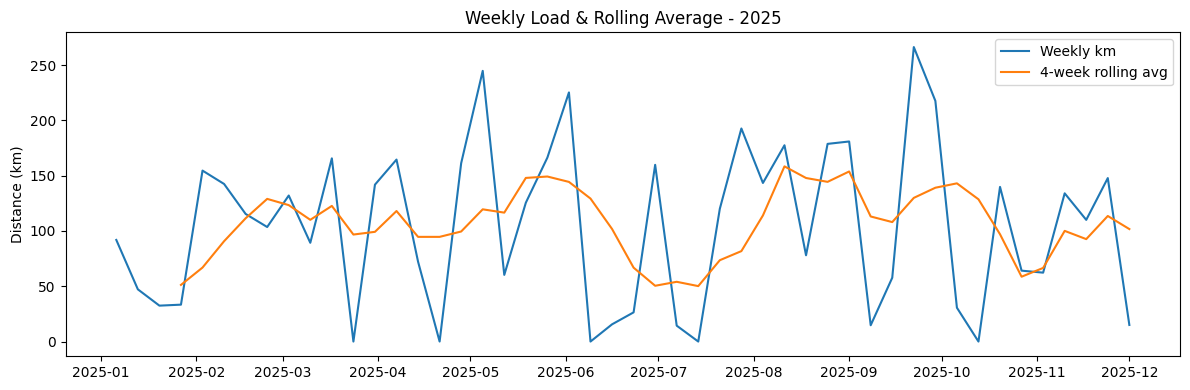

Active vs rest days - 2025:
  year: 2025
  active_days: 218
  rest_days: 147
  sessions: 243
  avg_sessions_per_active_day: 1.114678899082569


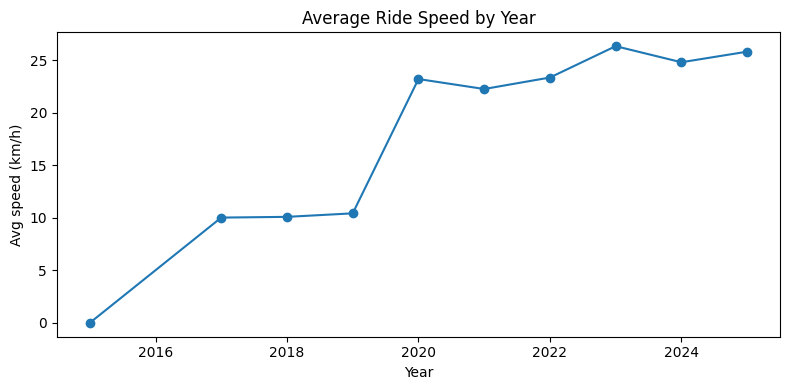

      avg_speed_kmh  median_speed_kmh   total_km  n_activities
year                                                          
2015       0.000000            0.0000     0.0000             1
2017      10.019531           10.0746   774.9549            64
2018      10.089056           10.1358  2848.2096           256
2019      10.423685           10.3032   615.7106            47
2020      23.202000           24.6420   125.0635             4
2021      22.255440           22.7988   556.0488            15
2022      23.346900           23.7546   848.4005            12
2023      26.331000           25.8642  1373.7700            24
2024      24.800564           27.8838  2208.7881            44
2025      25.807410           28.8612  4288.6986            80
Indoor vs outdoor - 2025:
              total_km  total_hours  n_activities  km_per_hour
sport_type                                                    
Ride         4288.6986   156.529167            80    27.398719
VirtualRide   504.9726    15.

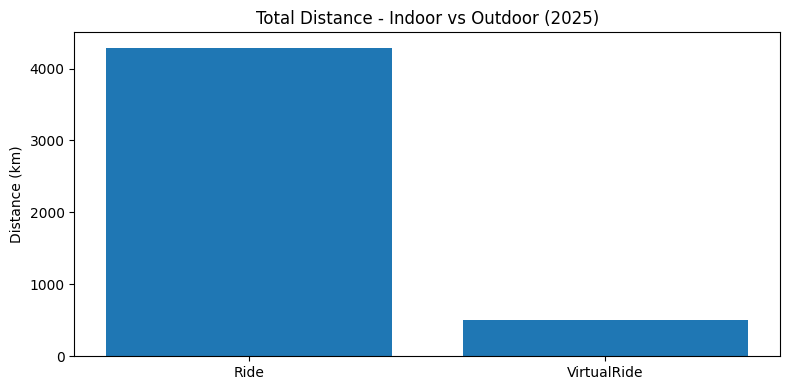

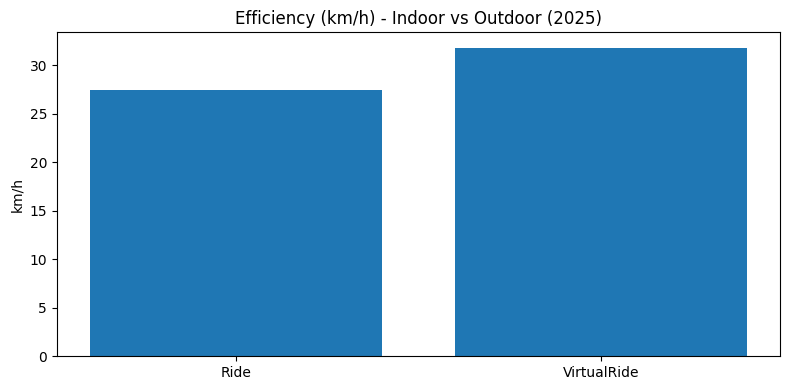

Climbing stats - 2025:
                 total_km  total_elev_m  n_activities   m_per_km  m_per_100km
sport_type                                                                   
Ride            4288.6986       54914.9            80   12.80456  1280.456034
Hike              69.5287        2328.4             9  33.488329  3348.832928
Run               66.0107         257.4             7   3.899368   389.936783
Canoeing          79.3604         222.0            11   2.797365   279.736493
VirtualRide      504.9726          68.0            21   0.134661    13.466077
Golf               1.0000           0.0             1        0.0          0.0
Swim               0.2880           0.0             1        0.0          0.0
Tennis             2.0000           0.0             1        0.0          0.0
VirtualRun         4.5000           0.0             2        0.0          0.0
WeightTraining     0.0000           0.0           110       <NA>         <NA>


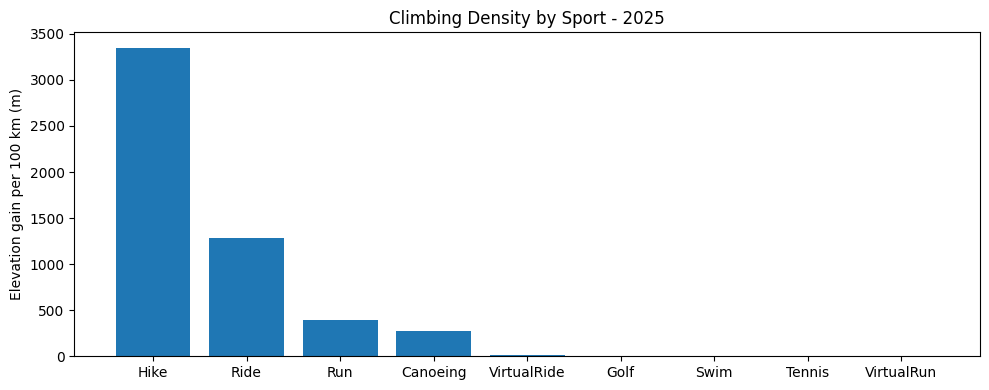

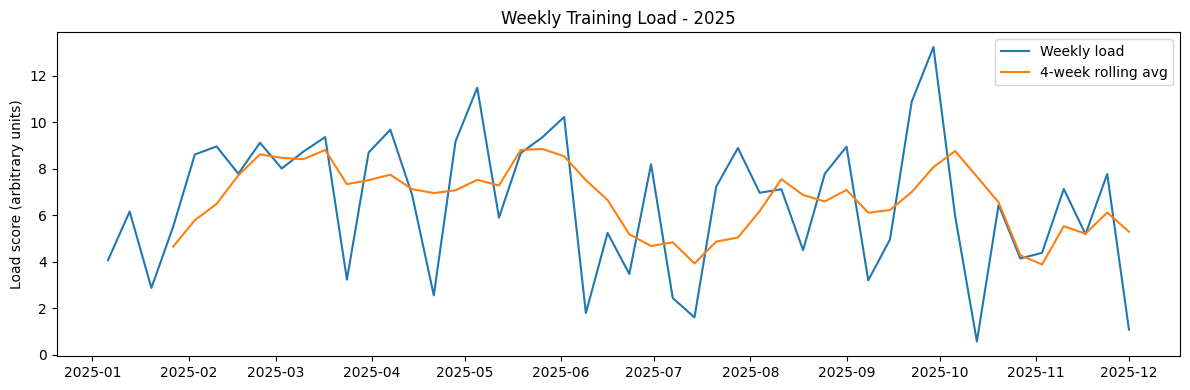

Forecast for 2025:
  Current km: 5016.4
  Daily avg (YTD): 15.16 km/day
  Forecast total: 5531.6 km
Goal progress - 2025:
  total_km: 5016.4 / 6000.0 (84%)
  total_hours: 329.3 / 350.0 (94%)
  n_active_days: 218.0 / 220.0 (99%)
  n_activities: 243.0 / 250.0 (97%)
  Ride.total_km: 4288.7 / 5500.0 (78%)
Best & worst periods - 2025:
  best_month: 5
  best_month_km: 812.3543
  worst_month: 6
  worst_month_km: 201.70589999999999
  best_week_start: 2025-09-22
  best_week_km: 266.22499999999997
  worst_week_start: 2025-10-13
  worst_week_km: 0.0


{'best_month': 5,
 'best_month_km': 812.3543,
 'worst_month': 6,
 'worst_month_km': 201.70589999999999,
 'best_week_start': datetime.date(2025, 9, 22),
 'best_week_km': 266.22499999999997,
 'worst_week_start': datetime.date(2025, 10, 13),
 'worst_week_km': 0.0}

In [19]:
# ==== EXTRA ANALYTICS ====
df = add_speed_columns(df)
df_with_load = compute_training_load(df)

year = 2025

compute_training_streaks(df, year)
weekly_load_with_rolling(df, year)
active_vs_rest_days(df, year)

speed_trend_by_year(df, "Ride")
indoor_vs_outdoor_stats(df, year)
climbing_analysis(df, year)

# Only if you know your max HR, e.g. 200
# heart_rate_zone_distribution(df, year, hr_max=200, sport_filter="Ride")

plot_weekly_training_load(df_with_load, year)

forecast_year_distance(df, year)

goals = {
    "total_km": 6000,
    "total_hours": 350,
    "n_active_days": 220,
    "n_activities": 250,
    "Ride.total_km": 5500,
}
training_goals_progress(df, year, goals)

best_and_worst_periods(df, year)


In [20]:
import matplotlib.pyplot as plt
import numpy as np

def _add_bar_labels(ax):
    for rect in ax.patches:
        height = rect.get_height()
        if np.isnan(height) or height <= 0:
            continue
        ax.annotate(
            f"{height:.0f}",
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=8,
        )

def plot_sport_type_overview_pretty(df: pd.DataFrame, year: int):
    overview = get_year_overview(df, year)
    by_sport = overview["by_sport"]
    if by_sport is None or by_sport.empty:
        return

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(by_sport.index, by_sport["total_km"])
    ax.set_ylabel("Distance (km)")
    ax.set_title(f"Distance per Sport Type – {year}")
    ax.tick_params(axis="x", rotation=30)
    _add_bar_labels(ax)
    fig.tight_layout()
    plt.show()


def plot_monthly_overview_pretty(df: pd.DataFrame, year: int):
    overview = get_year_overview(df, year)
    by_month = overview["by_month"]
    if by_month is None or by_month.empty:
        return

    # ensure all months 1–12 exist
    idx = range(1, 13)
    by_month = by_month.reindex(idx, fill_value=0)

    best_month = by_month["total_km"].idxmax()

    fig, ax = plt.subplots(figsize=(10, 4))
    bars = ax.bar(by_month.index, by_month["total_km"])
    ax.set_xlabel("Month")
    ax.set_ylabel("Distance (km)")
    ax.set_title(f"Distance per Month – {year}")
    ax.set_xticks(range(1, 13))

    # highlight best month
    for rect in bars:
        month = int(rect.get_x() + rect.get_width() / 2)
        if month == best_month:
            rect.set_linewidth(1.5)
            rect.set_edgecolor("black")
        height = rect.get_height()
        if height > 0:
            ax.annotate(
                f"{height:.0f}",
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha="center",
                va="bottom",
                fontsize=8,
            )

    fig.tight_layout()
    plt.show()


def plot_weekly_distance_pretty(df: pd.DataFrame, year: int):
    year_df = df[df["year"] == year].copy()
    if year_df.empty:
        print(f"No activities for year {year}")
        return

    tmp = year_df.set_index("start_date_local")
    weekly = tmp["distance_km"].resample("W").sum()

    fig, ax = plt.subplots(figsize=(12, 3.5))
    ax.plot(weekly.index, weekly.values, marker="o", linewidth=1)
    ax.fill_between(weekly.index, weekly.values, alpha=0.15)
    ax.set_ylabel("Distance (km)")
    ax.set_title(f"Weekly Distance Trend – {year}")
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()


def year_dashboard(df: pd.DataFrame, year: int, goals: dict | None = None):
    """
    High-level dashboard for a given year.
    - Prints textual summary
    - Optional goals progress
    - Draws 3 polished charts
    """
    print("=" * 70)
    print(f"🚴 YEARLY DASHBOARD — {year}")
    print("=" * 70)

    summary = get_year_summary(df, year)
    if summary["n_activities"] == 0:
        print(f"No activities found for {year}.")
        return

    # Basic metrics
    print("\n🔹 Overview")
    print(f"  Total distance : {summary['total_km']:.1f} km")
    print(f"  Total moving   : {summary['total_hours']:.1f} hours")
    print(f"  Activities     : {int(summary['n_activities'])}")
    print(f"  Active days    : {int(summary['n_active_days'])}")

    # Best / worst periods
    bw = best_and_worst_periods(df, year)
    print("\n🔹 Best & Worst Periods")
    print(f"  Best month : {bw['best_month']} ({bw['best_month_km']:.0f} km)")
    print(f"  Worst month: {bw['worst_month']} ({bw['worst_month_km']:.0f} km)")
    print(f"  Best week  : starting {bw['best_week_start']} "
          f"({bw['best_week_km']:.0f} km)")
    print(f"  Worst week : starting {bw['worst_week_start']} "
          f"({bw['worst_week_km']:.0f} km)")

    # Forecast
    print("\n🔹 Forecast")
    forecast = forecast_year_distance(df, year)

    # Goals progress (optional)
    if goals:
        print("\n🔹 Goal Tracking")
        training_goals_progress(df, year, goals)

    # Training streaks
    print("\n🔹 Streaks")
    compute_training_streaks(df, year)

    # === VISUALS ===
    print("\n📊 Charts\n")

    plot_sport_type_overview_pretty(df, year)
    plot_monthly_overview_pretty(df, year)
    plot_weekly_distance_pretty(df, year)


🚴 YEARLY DASHBOARD — 2025

🔹 Overview
  Total distance : 5016.4 km
  Total moving   : 329.3 hours
  Activities     : 243
  Active days    : 218
Best & worst periods - 2025:
  best_month: 5
  best_month_km: 812.3543
  worst_month: 6
  worst_month_km: 201.70589999999999
  best_week_start: 2025-09-22
  best_week_km: 266.22499999999997
  worst_week_start: 2025-10-13
  worst_week_km: 0.0

🔹 Best & Worst Periods
  Best month : 5 (812 km)
  Worst month: 6 (202 km)
  Best week  : starting 2025-09-22 (266 km)
  Worst week : starting 2025-10-13 (0 km)

🔹 Forecast
Forecast for 2025:
  Current km: 5016.4
  Daily avg (YTD): 15.16 km/day
  Forecast total: 5531.6 km

🔹 Goal Tracking
Goal progress - 2025:
  total_km: 5016.4 / 6000.0 (84%)
  total_hours: 329.3 / 350.0 (94%)
  n_active_days: 218.0 / 220.0 (99%)
  n_activities: 243.0 / 250.0 (97%)
  Ride.total_km: 4288.7 / 5500.0 (78%)

🔹 Streaks
Training streaks (2025):
  Longest streak: 9 days (2025-07-30 → 2025-08-07)
  Current streak: 0 days

📊 Chart

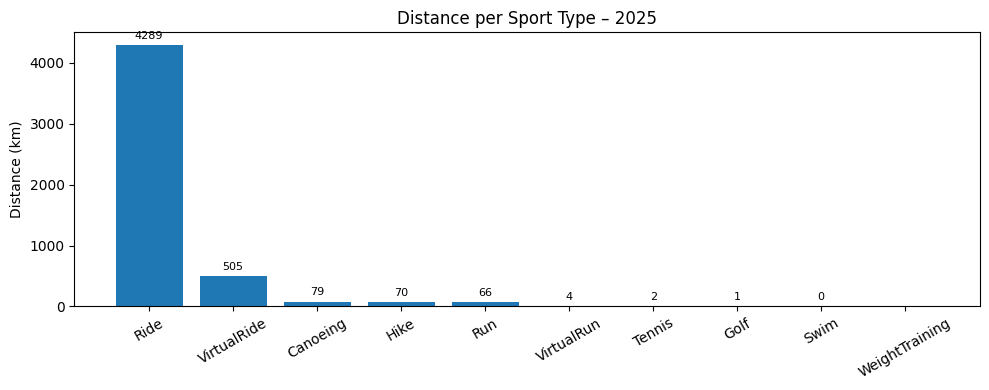

Overview for 2025:
  Total activities: 243
  Total distance:   5016.4 km
  Total moving:     329.3 hours

Distance and time by sport_type:
                 total_km  total_hours  n_activities
sport_type                                          
Ride            4288.6986   156.529167            80
VirtualRide      504.9726    15.879722            21
Canoeing          79.3604     8.166389            11
Hike              69.5287    18.076944             9
Run               66.0107     5.371667             7
VirtualRun         4.5000     0.366667             2
Tennis             2.0000     1.000000             1
Golf               1.0000     2.000000             1
Swim               0.2880     0.094167             1
WeightTraining     0.0000   121.862500           110


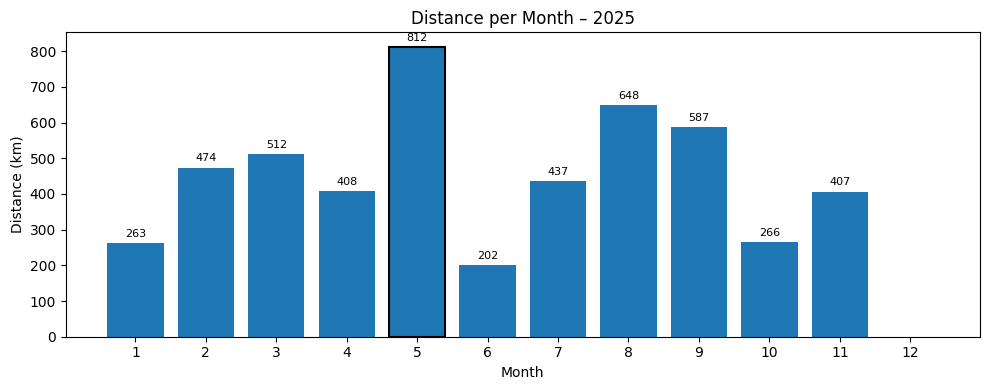

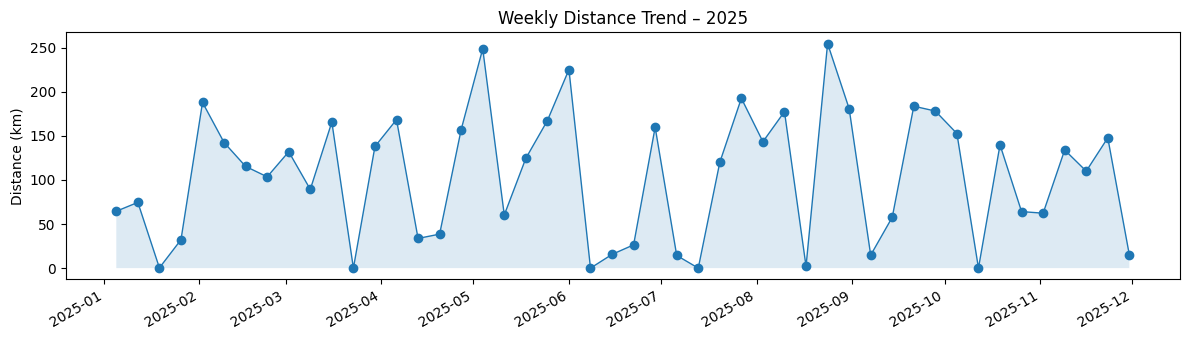

In [21]:
year = 2025

goals = {
    "total_km": 6000,
    "total_hours": 350,
    "n_active_days": 220,
    "n_activities": 250,
    "Ride.total_km": 5500,
}

year_dashboard(df, year, goals=goals)